In [1]:
import numpy as np
import pandas as pd
import pickle

df = pd.read_json("data/coreference.jsonl", lines=True)
data = pickle.load(open("coreference_qwen3-8b_rotated-space_activations.pkl", "rb"))

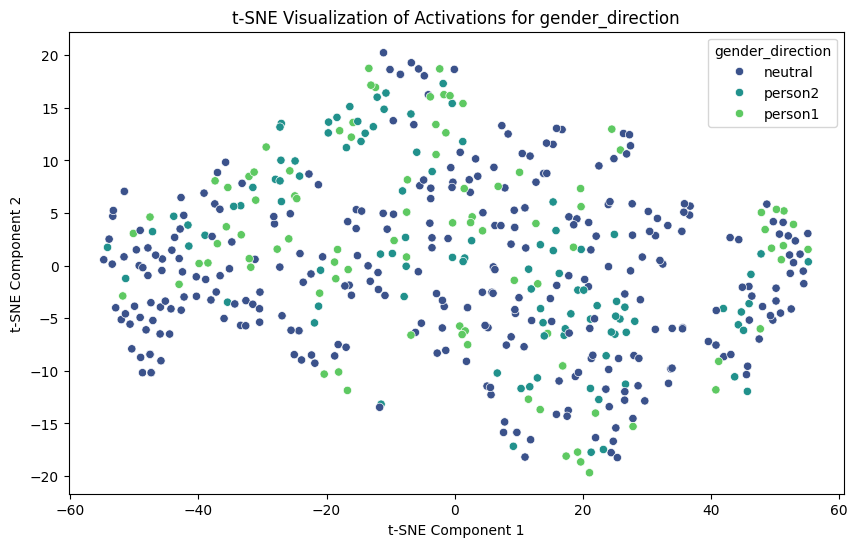

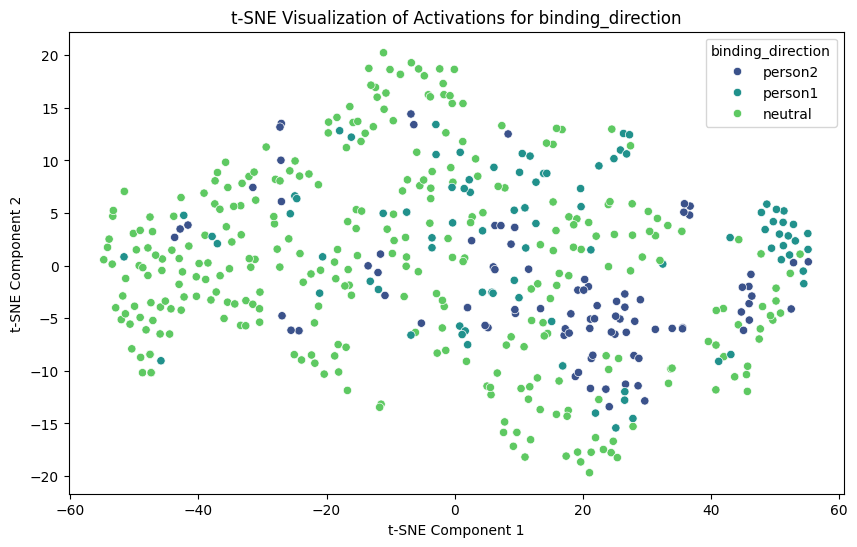

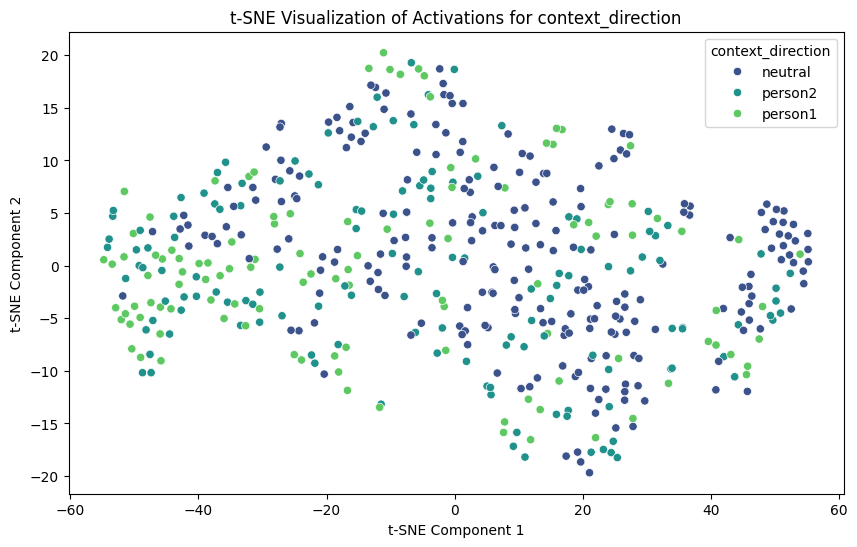

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


for key in data.keys():
    X = np.stack(data[key], axis=0)
    labels = df[key].tolist()
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette="viridis")
    plt.title(f"t-SNE Visualization of Activations for {key}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title=key)
    plt.show()

In [1]:
import os
from src.utils.models import load_from_checkpoint

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

/data/ykliu/.conda/envs/pyyk/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loaded = load_from_checkpoint("results/qwen3-8b_coreference_rotated-space_256")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


In [3]:
loaded["intervention_module"].var_proj

Parameter containing:
tensor([[-0.0029, -0.0055, -0.0230,  ...,  0.0117, -0.0092,  0.0219],
        [-0.0063,  0.0024,  0.0401,  ...,  0.0547, -0.0451, -0.0270],
        [-0.0202,  0.0015,  0.0011,  ..., -0.0183, -0.0354,  0.0091]],
       requires_grad=True)

In [6]:
base_example = {
    "sentence": "The waiter served the famous actress. He was hoping for a large tip.",
    "person1": "the waiter",
    "person2": "the famous actress",
    "pronoun": "He",
    "gender_direction": "neutral",
    "binding_direction": "neutral",
    "context_direction": "person1"
}

source_example = {
    "sentence": "The waiter served the gentleman his dinner.",
    "person1": "the waiter",
    "person2": "the gentleman",
    "pronoun": "his",
    "gender_direction": "neutral",
    "binding_direction": "neutral",
    "context_direction": "person2"
}

base_example = loaded["task"].format_example(base_example)
source_example = loaded["task"].format_example(source_example)
base_example

{'sentence': 'The waiter served the famous actress. He was hoping for a large tip.',
 'person1': 'the waiter',
 'person2': 'the famous actress',
 'pronoun': 'He',
 'gender_direction': 'neutral',
 'binding_direction': 'neutral',
 'context_direction': 'person1',
 'question': 'Sentence: The waiter served the famous actress. He was hoping for a large tip.\nQuestion: Who does "He" refer to?\nA. the waiter\nB. the famous actress\nRespond with "A" or "B".',
 'answer': 'person1'}

In [7]:
loaded["tokenizer"].padding_side = "left"
base_inputs = loaded["tokenizer"](
    base_example["question"], return_tensors="pt", padding=True, truncation=True, max_length=256
)
source_inputs = loaded["tokenizer"](
    source_example["question"], return_tensors="pt", padding=True, truncation=True, max_length=256
)

In [8]:
interv_id = loaded["task"].var2id("binding_direction")

loaded["model"].run_intervention(
    base_input_ids=base_inputs.input_ids,
    base_attention_mask=base_inputs.attention_mask,
    source_input_ids=source_inputs.input_ids,
    source_attention_mask=source_inputs.attention_mask,
    intervention_variables=[{"id": 2, "interv_at": "model.layers[20]"}],
    intervention_module=loaded["intervention_module"],
    output_space=loaded["tokenizer"].convert_tokens_to_ids(["A", "B"]),
    top_k=409,
)

IntervenedOutput(loss=None, original_logits=tensor([[21.8737, 12.0666]], grad_fn=<IndexBackward0>), modified_logits=tensor([[22.1213, 16.7044]], grad_fn=<IndexBackward0>), original_hidden_states={'model.layers[20]': tensor([[[ 1.8600e+00, -4.1734e-01,  4.1990e+00,  ..., -8.2222e-02,
           1.7088e+00,  1.8266e+00],
         [-1.9530e+00, -2.7755e-01, -4.8003e-01,  ..., -3.5845e-01,
           4.1978e-01, -8.6512e-01],
         [-2.1462e+00,  4.3073e-01,  2.5784e-01,  ..., -1.0059e-01,
          -2.3496e-03, -5.0834e-01],
         ...,
         [ 2.6182e-01,  1.1335e+00, -3.0998e-01,  ...,  2.9654e-01,
          -2.2567e-01,  1.5563e-01],
         [ 4.8007e-01,  3.8958e-01,  2.2126e-01,  ...,  7.2030e-01,
           1.0564e+00,  5.2709e-01],
         [-1.3170e-01, -2.5899e-01,  1.8565e+00,  ..., -1.9894e-01,
           1.8543e+00, -6.4285e-01]]], grad_fn=<AddBackward0>)}, modified_hidden_states={'model.layers[20]': tensor([[[ 1.8600e+00, -4.1734e-01,  4.1990e+00,  ..., -8.2222e-02,
